In [ ]:
!pip install metar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 3.5 MB/s eta 0:00:00


In [ ]:
from metar import Metar as mt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re
import seaborn as sns
from scipy import stats
import io

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
raw = pd.read_csv('public.csv', on_bad_lines='warn')

In [ ]:
raw.head(3)

,flightid,hora_ref,origem,destino,url_img_satelite,metaf,metar,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera
0,504a62621cd231d6ab67e674ce538cd3,2022-06-01T01:00:00Z,SBCF,SBFL,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBFL 010000Z 17009KT 140V200 9999 BKN030...,0,1,0.0
1,b0fd0f83644625ecc21f5261e8e5e347,2022-06-01T01:00:00Z,SBPA,SBFL,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBFL 010000Z 17009KT 140V200 9999 BKN030...,0,1,0.0
2,1210f0ca07ddca00d09a3e02d3b100d8,2022-06-01T01:00:00Z,SBSP,SBCF,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018=,0,0,0.0


In [ ]:
print(len(raw))

302399


# **tratando nulos**

In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302399 entries, 0 to 302398
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   flightid                       302399 non-null  object 
 1   hora_ref                       302399 non-null  object 
 2   origem                         302399 non-null  object 
 3   destino                        302399 non-null  object 
 4   url_img_satelite               298666 non-null  object 
 5   metaf                          155737 non-null  object 
 6   metar                          300770 non-null  object 
 7   prev_troca_cabeceira           302399 non-null  int64  
 8   troca_cabeceira_hora_anterior  302399 non-null  int64  
 9   espera                         211679 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 23.1+ MB


In [ ]:
# # prompt: criar for para ler cada linha de um dataframe chamado raw
# x = 0
# for index, row in raw.iterrows():
#   # Your code here
#   if type(row['metaf']) == float: x+=1
#   # print(row['metaf'], row['metar'])

# print(x)
# #quase metade são nulos

146662


In [ ]:
raw2 = raw.dropna()
print(raw2.isnull().sum())
print('-'*70)
print(raw2.info())

flightid                         0
hora_ref                         0
origem                           0
destino                          0
url_img_satelite                 0
metaf                            0
metar                            0
prev_troca_cabeceira             0
troca_cabeceira_hora_anterior    0
espera                           0
dtype: int64
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 88189 entries, 7 to 211678
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   flightid                       88189 non-null  object 
 1   hora_ref                       88189 non-null  object 
 2   origem                         88189 non-null  object 
 3   destino                        88189 non-null  object 
 4   url_img_satelite               88189 non-null  object 
 5   metaf                          88189

# **criando novas features**

### metar features

In [ ]:
def WindOrigin(str):
  list = str.split()
  if len(list) > 3:
    return list[0] + list[1] + list[2]
  else:
    return list[0]

def ParseMetar(metarcode,month,year):
  try:
    report = mt.Metar(metarcode)
    return report
  except ValueError as e:
      print(f"ValueError: {e}")
      return mt.Metar(metarcode, month=month,year=year)
  except mt.ParserError as e:
      print(f"ParserError: {e}")
      return mt.Metar(metarcode, month=month,year=year)

In [ ]:
new_metar_features_raw = []

for index, row in raw2.iterrows():
  # print(index)

  metarcode = row['metar']

  try:
    # print(f'OK')
    report = mt.Metar(metarcode)
  except mt.ParserError:
    # print(index)
    # print(f"Invalid day format in METAR code: {metarcode}")
    report =  np.nan

  if report is not np.nan:
    try:
      # print(report)
        metar_infos = [
            int(str(report.wind_speed).split()[0]),
            str(report.wind_dir).split()[0],
            # WindOrigin(report.wind()),
            int(str(report.vis).split()[-2]),
            # report.sky
            # 'x'
            float(str(report.temp).split()[0]),
            float(str(report.dewpt).split()[0]),
            float(str(report.press).split()[0])
        ]

        new_metar_features_raw.append(metar_infos)
    except IndexError:
        print(report)
    except ValueError as e:
        # print(f"ValueError: {e}")
        new_metar_features_raw.append([None,None,None,None,None,None])
  else:
    # print(f'metar error -> {report}')
    new_metar_features_raw.append([None,None,None,None,None,None])

print(f'lenght: {len(new_metar_features_raw)}\n array: {new_metar_features_raw}')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(f'metar column lenght: {len(new_metar_features_raw)}')

print(f'raw lenght {len(raw2)}')
#gritos internos de felicidade

In [ ]:
df_metar_features = pd.DataFrame(new_metar_features_raw,columns=['wind_speed','wind_dir','visibility','temperature','dewpt','pressure'])

# df_metar_features.head(3)

wind_speed = list(df_metar_features['wind_speed'])
wind_dir = list(df_metar_features['wind_dir'])
visibility = list(df_metar_features['visibility'])
temperature = list(df_metar_features['wind_speed'])
dewpt = list(df_metar_features['dewpt'])
pressure = list(df_metar_features['pressure'])
# print(wind_speed)

raw2['wind_speed'] = wind_speed
raw2['wind_dir'] = wind_dir
raw2['visibility'] = visibility
raw2['temperature'] = temperature
raw2['dewpt'] = dewpt
raw2['pressure'] = pressure

raw2.info()

metar column lenght: 88189
raw lenght 88189
<class 'pandas.core.frame.DataFrame'>
Index: 88189 entries, 7 to 211678
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   flightid                       88189 non-null  object 
 1   hora_ref                       88189 non-null  object 
 2   origem                         88189 non-null  object 
 3   destino                        88189 non-null  object 
 4   url_img_satelite               88189 non-null  object 
 5   metaf                          88189 non-null  object 
 6   metar                          88189 non-null  object 
 7   prev_troca_cabeceira           88189 non-null  int64  
 8   troca_cabeceira_hora_anterior  88189 non-null  int64  
 9   espera                         88189 non-null  float64
 10  wind_speed                     88187 non-null  float64
 11  wind_dir                       88187 non-null  object 
 12  visibi

<ipython-input-11-e64e7d736e14>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw2['wind_speed'] = wind_speed
<ipython-input-11-e64e7d736e14>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw2['wind_dir'] = wind_dir
<ipython-input-11-e64e7d736e14>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

### removendo nulos oriundos da feature metar

In [ ]:
raw3 = raw2.dropna()
print(raw3.isnull().sum())
print('-'*70)
print(raw3.info())

flightid                         0
hora_ref                         0
origem                           0
destino                          0
url_img_satelite                 0
metaf                            0
metar                            0
prev_troca_cabeceira             0
troca_cabeceira_hora_anterior    0
espera                           0
wind_speed                       0
wind_dir                         0
visibility                       0
temperature                      0
dewpt                            0
pressure                         0
dtype: int64
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 88187 entries, 7 to 211678
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   flightid                       88187 non-null  object 
 1   hora_ref                       88187 non-null  object 
 2   origem

### datetime features

In [ ]:
raw3['hora_ref'] = pd.to_datetime(raw3['hora_ref'])

# Create new columns
raw3['hour'] = raw3['hora_ref'].dt.hour
raw3['year'] = raw3['hora_ref'].dt.year
raw3['month'] = raw3['hora_ref'].dt.month
raw3['weekday'] = raw3['hora_ref'].dt.strftime('%A')

raw3.head(3)

<ipython-input-13-cd010c397120>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw3['hora_ref'] = pd.to_datetime(raw3['hora_ref'])
<ipython-input-13-cd010c397120>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw3['hour'] = raw3['hora_ref'].dt.hour
<ipython-input-13-cd010c397120>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,flightid,hora_ref,origem,destino,url_img_satelite,metaf,metar,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,wind_speed,wind_dir,visibility,temperature,dewpt,pressure,hour,year,month,weekday
7,2c6941c4b747277aab4dd189fb23e1a4,2022-06-01 01:00:00+00:00,SBRF,SBGR,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBGR 010100Z 11008KT 1000 BR OVC033...,METAR SBGR 010000Z 13005KT 9999 OVC009 16/15 Q...,0,0,0.0,5.0,130,10000.0,5.0,15.0,1019.0,1,2022,6,Wednesday
9,6c995721654348064df0e1b2c3c99bb9,2022-06-01 01:00:00+00:00,SBPA,SBGR,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBGR 010100Z 11008KT 1000 BR OVC033...,METAR SBGR 010000Z 13005KT 9999 OVC009 16/15 Q...,0,0,0.0,5.0,130,10000.0,5.0,15.0,1019.0,1,2022,6,Wednesday
11,1b44026d2959666741d35f4b2e1545a5,2022-06-01 01:00:00+00:00,SBGR,SBGL,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBGL 010100Z 02001KT 2000 BR OVC011 ...,METAR SBGL 010000Z 10002KT 9999 SCT020 BKN040 ...,0,0,0.0,2.0,100,10000.0,2.0,20.0,1016.0,1,2022,6,Wednesday


### ponte aérea

In [ ]:
raw3['fly_line'] = raw3['origem'] + ' ' + raw3['destino']

<ipython-input-14-f069c1eb7515>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw3['fly_line'] = raw3['origem'] + ' ' + raw3['destino']


### imagem de satélite

In [ ]:
from PIL import Image
import numpy as np
import requests
from io import BytesIO
from IPython.display import display

http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/06/S11635384_202206010100.jpg
None


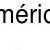

In [ ]:
teste = raw3['url_img_satelite']
x = list(teste)
url = x[0]

response = requests.get(url)
print(url)
print(response.raise_for_status())

# print(response.content)

img = Image.open(BytesIO(response.content))

# img_array = np.array(img)

crop_area = (50,50,100,100)

cropped_img = img.crop(crop_area)

display(cropped_img)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **análise descritiva**

In [ ]:
raw3.head(3)

,flightid,hora_ref,origem,destino,url_img_satelite,metaf,metar,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,...,wind_dir,visibility,temperature,dewpt,pressure,hour,year,month,weekday,fly_line
7,2c6941c4b747277aab4dd189fb23e1a4,2022-06-01 01:00:00+00:00,SBRF,SBGR,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBGR 010100Z 11008KT 1000 BR OVC033...,METAR SBGR 010000Z 13005KT 9999 OVC009 16/15 Q...,0,0,0.0,...,130,10000.0,5.0,15.0,1019.0,1,2022,6,Wednesday,SBRF SBGR
9,6c995721654348064df0e1b2c3c99bb9,2022-06-01 01:00:00+00:00,SBPA,SBGR,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBGR 010100Z 11008KT 1000 BR OVC033...,METAR SBGR 010000Z 13005KT 9999 OVC009 16/15 Q...,0,0,0.0,...,130,10000.0,5.0,15.0,1019.0,1,2022,6,Wednesday,SBPA SBGR
11,1b44026d2959666741d35f4b2e1545a5,2022-06-01 01:00:00+00:00,SBGR,SBGL,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBGL 010100Z 02001KT 2000 BR OVC011 ...,METAR SBGL 010000Z 10002KT 9999 SCT020 BKN040 ...,0,0,0.0,...,100,10000.0,2.0,20.0,1016.0,1,2022,6,Wednesday,SBGR SBGL


### removendo features

In [ ]:
features = raw3.drop(labels=['flightid','url_img_satelite','metaf','metar','hora_ref','origem','destino','espera'], axis=1)
columns_names = features.columns.values
features.head(3)

,prev_troca_cabeceira,troca_cabeceira_hora_anterior,wind_speed,wind_dir,visibility,temperature,dewpt,pressure,hour,year,month,weekday,fly_line
7,0,0,5.0,130,10000.0,5.0,15.0,1019.0,1,2022,6,Wednesday,SBRF SBGR
9,0,0,5.0,130,10000.0,5.0,15.0,1019.0,1,2022,6,Wednesday,SBPA SBGR
11,0,0,2.0,100,10000.0,2.0,20.0,1016.0,1,2022,6,Wednesday,SBGR SBGL


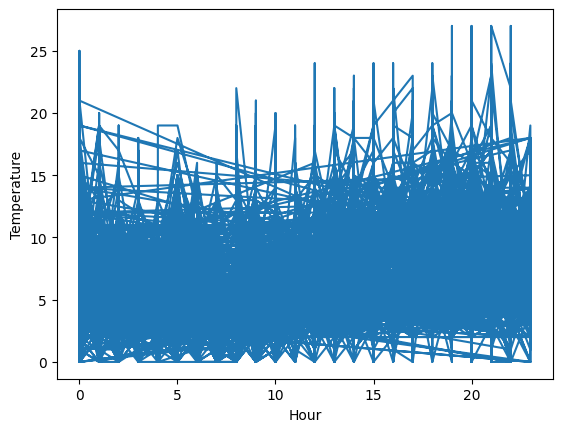

In [ ]:
# @title Temperature over time

import matplotlib.pyplot as plt
plt.plot(features['hour'], features['temperature'])
plt.ylabel('Temperature')
_ = plt.xlabel('Hour')

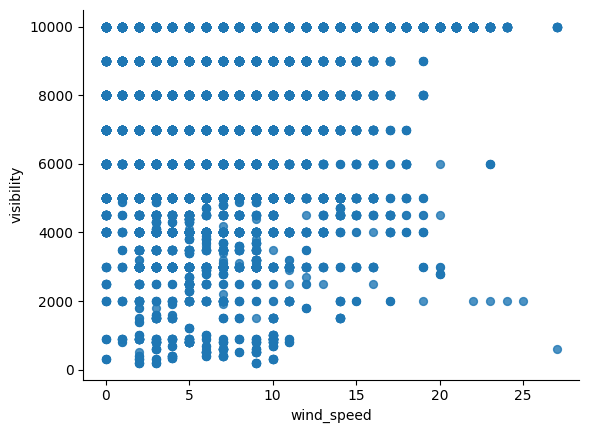

In [ ]:
# @title wind_speed vs visibility

from matplotlib import pyplot as plt
features.plot(kind='scatter', x='wind_speed', y='visibility', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

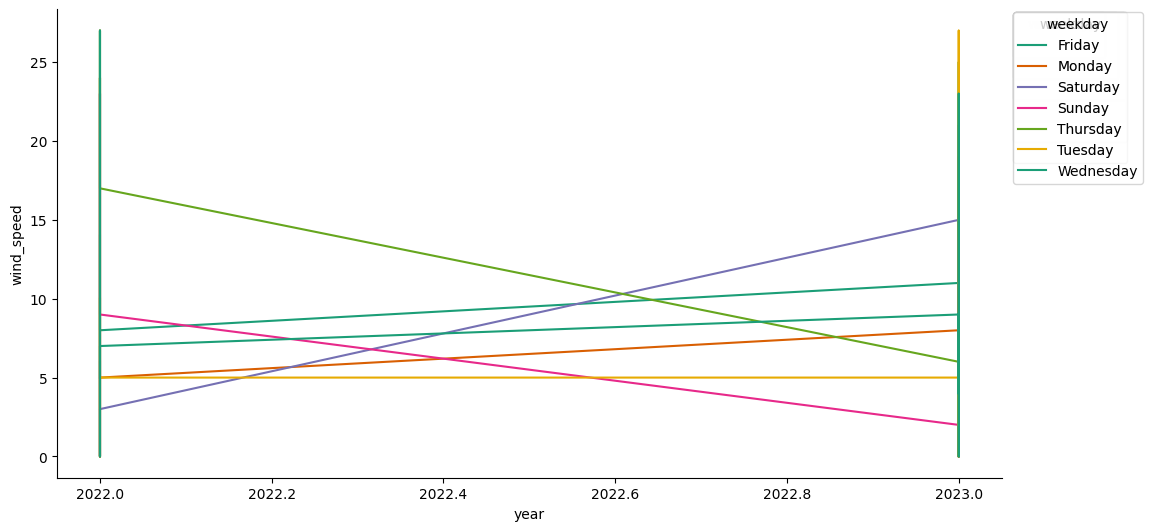

In [ ]:
# @title year vs wind_speed

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['wind_speed']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = features.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('weekday')):
  _plot_series(series, series_name, i)
  fig.legend(title='weekday', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('wind_speed')

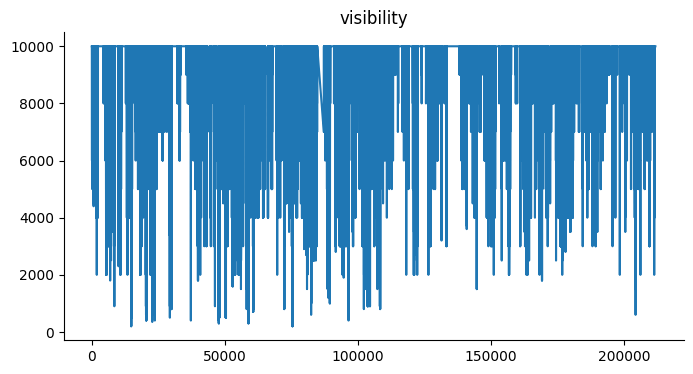

In [ ]:
# @title visibility

from matplotlib import pyplot as plt
features['visibility'].plot(kind='line', figsize=(8, 4), title='visibility')
plt.gca().spines[['top', 'right']].set_visible(False)

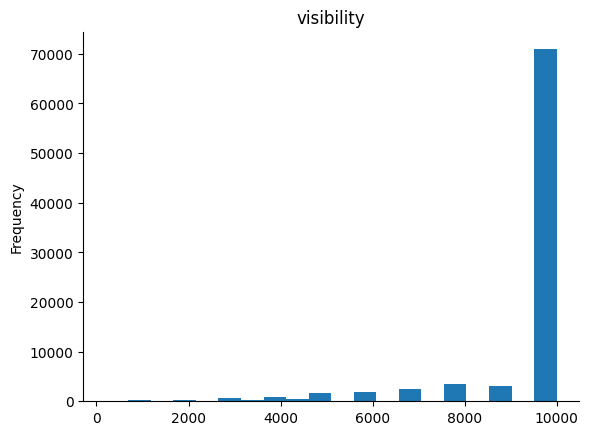

In [ ]:
# @title visibility

from matplotlib import pyplot as plt
features['visibility'].plot(kind='hist', bins=20, title='visibility')
plt.gca().spines[['top', 'right',]].set_visible(False)

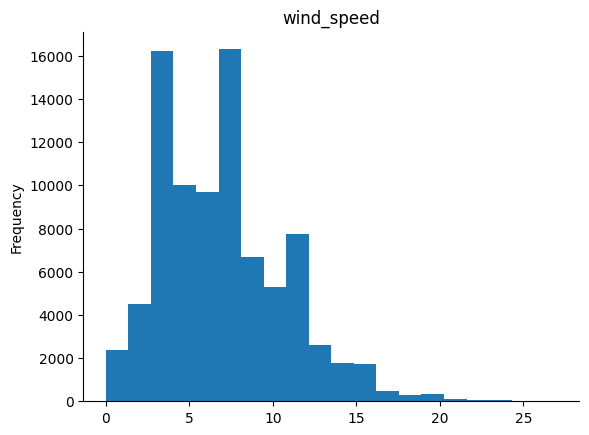

In [ ]:
# @title wind_speed

from matplotlib import pyplot as plt
features['wind_speed'].plot(kind='hist', bins=20, title='wind_speed')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
sample = raw3['espera']

In [ ]:
sample = LabelEncoder().fit_transform(sample)
np.unique(sample)

array([0, 1])

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86295 entries, 7 to 211678
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   prev_troca_cabeceira           86295 non-null  int64  
 1   troca_cabeceira_hora_anterior  86295 non-null  int64  
 2   wind_speed                     86295 non-null  float64
 3   wind_dir                       86295 non-null  object 
 4   visibility                     86295 non-null  float64
 5   temperature                    86295 non-null  float64
 6   dewpt                          86295 non-null  float64
 7   pressure                       86295 non-null  float64
 8   hour                           86295 non-null  int32  
 9   year                           86295 non-null  int32  
 10  month                          86295 non-null  int32  
 11  weekday                        86295 non-null  object 
 12  fly_line                       86295 non-null  obj

# **implementando o modelo - KNN**

---



In [ ]:
stand_ord = ColumnTransformer(transformers=[
    ('categoricas', OrdinalEncoder(), make_column_selector(dtype_include=['object','bool'])),
    ('numéricas',StandardScaler(), make_column_selector(dtype_include=['float64','int64','int32']))],
    remainder='passthrough',
    verbose_feature_names_out= False,)

stand_dum = ColumnTransformer(transformers=[
    ('categoricas', OneHotEncoder(), make_column_selector(dtype_include=['object','bool'])),
    ('numéricas',StandardScaler(), make_column_selector(dtype_include=['float64','int64','int32']))],
    remainder='passthrough',
    verbose_feature_names_out= False,)

norm_ord = ColumnTransformer(transformers=[
    ('categoricas', OrdinalEncoder(), make_column_selector(dtype_include=['object','bool'])),
    ('numéricas',MinMaxScaler(), make_column_selector(dtype_include=['float64','int64','int32']))],
    remainder='passthrough',
    verbose_feature_names_out= False,)

norm_dum = ColumnTransformer(transformers=[
    ('categoricas', OneHotEncoder(), make_column_selector(dtype_include=['object','bool'])),
    ('numéricas',MinMaxScaler(), make_column_selector(dtype_include=['float64','int64','int32']))],
    remainder='passthrough',
    verbose_feature_names_out= False,)

In [ ]:
features_stand_ord = pd.DataFrame(stand_ord.fit_transform(features), columns=stand_ord.get_feature_names_out())

features_norm_ord = pd.DataFrame(norm_ord.fit_transform(features), columns=norm_ord.get_feature_names_out())

In [ ]:
features_stand_ord = features_stand_ord[columns_names]

features_norm_ord = features_norm_ord[columns_names]

In [ ]:
F_so_train, F_so_test, S_so_train, S_so_test = train_test_split(features_stand_ord, sample, random_state=42,test_size=0.30)

F_no_train, F_no_test, S_no_train, S_no_test = train_test_split(features_norm_ord, sample, random_state=42,test_size=0.30)

In [ ]:
k = 10
classifier_knn_1 = KNeighborsClassifier(n_neighbors=k)
classifier_knn_2 = KNeighborsClassifier(n_neighbors=k)

In [ ]:
classifier_knn_1.fit(F_so_train,S_so_train)

classifier_knn_2.fit(F_no_train,S_no_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
predict_SO = classifier_knn_1.predict(F_so_test)
predict_NO = classifier_knn_2.predict(F_no_test)

### results

In [ ]:
accuracy_SO = accuracy_score(S_so_test, predict_SO)
accuracy_NO = accuracy_score(S_no_test, predict_NO)
print(f'Standardization and OrdinalEncoder: {round(accuracy_SO*100,6)}%')
print(f'Normalization and OrdinalEncoder: {round(accuracy_NO*100,6)}%')

Standardization and OrdinalEncoder: 97.717177%
Normalization and OrdinalEncoder: 97.705589%


<Axes: >

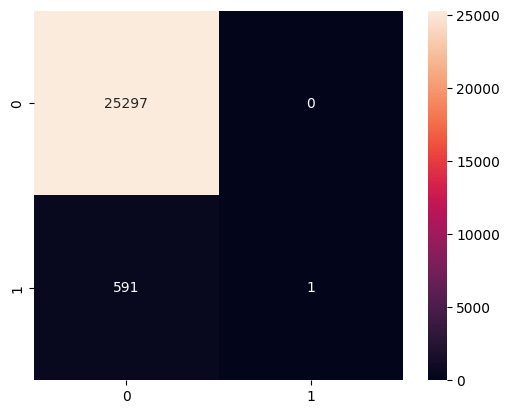

In [ ]:
confusionMatrix_SO = confusion_matrix(S_so_test,predict_SO)
sns.heatmap(confusionMatrix_SO, square=True, annot=True, cbar=True, fmt='d')

In [ ]:
metrics = classification_report(S_so_test,predict_SO)
print(metrics)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     25297
           1       1.00      0.00      0.00       592

    accuracy                           0.98     25889
   macro avg       0.99      0.50      0.50     25889
weighted avg       0.98      0.98      0.97     25889



## qual o melhor valor para K?

In [ ]:
train = []
test = []

ks = range(1,30)

for k in ks:
  classifier_knn = KNeighborsClassifier(n_neighbors = k)
  classifier_knn.fit(F_so_train, S_so_train)
  train.append(accuracy_score(S_so_train, classifier_knn.predict(F_so_train)))
  test.append(accuracy_score(S_so_test, classifier_knn.predict(F_so_test)))

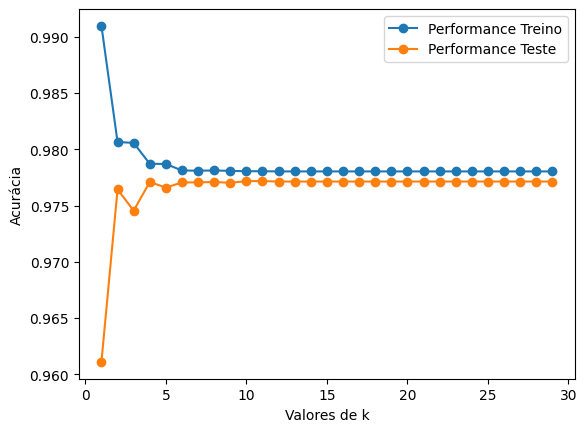

In [ ]:
plt.plot(ks, train, label = "Performance Treino", marker = 'o')
plt.plot(ks, test, label = "Performance Teste", marker = 'o')
plt.xlabel('Valores de k')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [ ]:
print(f'Melhor K no Teste: {test.index(max(test))}')
print(f'Melhor Acurrácia: {round(max(test)*100,4)}%')
#print(test)

Melhor K no Teste: 9
Melhor Acurrácia: 97.7172%


# **cross validation**

In [ ]:
knn = KNeighborsClassifier()

params = {'n_neighbors': ks}

grid = GridSearchCV(knn, params, cv=5)
grid.fit(F_so_train, S_so_train)

print(f'Melhor valor de K: {grid.best_params_}')
print(f'Melhor classificador: {grid.best_estimator_}')
print(f'Melhor score (médio): {round(grid.best_score_*100,4)}%')

Melhor valor de K: {'n_neighbors': 10}
Melhor classificador: KNeighborsClassifier(n_neighbors=10)
Melhor score (médio): 97.8032%


# testar besteiras abaixo da linha

linha

In [ ]:
for index, row in raw2.iterows:
  if ParseMetar(row,2,2024) is not None:


In [ ]:
metar_test = raw['metar'][0]

print(metar_test)
print('-------------')

report = mt.Metar(metar_test)
print(report)

print('-------------')

# Parsed information
# print("Station:", report.station_id) nao preciso saber daonde a informação vem, premissa que tudo é confiável
# print("Time:", report.time) mais relevante o horário do voo do que o horário que informação foi colata

speed = int(str(report.wind_speed).split()[0])
direction = report.wind_dir
# def WindOrigin(str):
#   list = str.split()
#   return list[0] + list[1] + list[2]
origin = WindOrigin(report.wind())
# direction_from = report.wind_dir_from - esse valor é o valor debaixo do range que o valor de cima esta
print(f'Wind: \n  Speed: {speed}\n  Direction to: {direction}\n  Origin City: {origin}')

print("Visibility:", int(str(report.vis).split()[-2]))
print(f'Sky Conditions: \n  Caracteristics: {report.sky[0][0]}\n  Feets: {int(str(report.sky[0][1]).split()[0])}')

print("Temperature:", float(str(report.temp).split()[0]))

print("Dew point:",float(str(report.dewpt).split()[0]))

print("Pressure (hPa):",float(str(report.press).split()[0]))

In [ ]:
code = raw2['metar'][36470]

report = mt.Metar(code)
print(report.wind())
# print([
#     int(str(report.wind_speed).split()[0]),
#     str(report.wind_dir).split()[0],
#     # WindOrigin(report.wind()),
#     int(str(report.vis).split()[-2]),
#     # report.sky
#     # 'x'
#     float(str(report.temp).split()[0]),
#     float(str(report.dewpt).split()[0]),
#     float(str(report.press).split()[0])
# ])

ENE to SSE at 6 knots
